In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [48]:
import hickle

from ase.io import read

import numpy as np

import torch
torch.set_default_dtype(torch.float64)

from mlelec.data.dataset import QMDataset
from mlelec.data.mldataset import MLDataset
from mlelec.models.linear_integrated import LinearModelPeriodic
from mlelec.utils.pbc_utils import blocks_to_matrix
from mlelec.utils.twocenter_utils import _to_uncoupled_basis, unfix_orbital_order
from mlelec.metrics import Eigval_loss, L2_loss_meanzero, L2_loss
import metatensor.torch as mts
from metatensor.learn import DataLoader

import os
os.environ["PYSCFAD_BACKEND"] = "torch"
from pyscf import gto
from pyscfad import numpy as pynp
from pyscfad import ops
from pyscfad.ml.scf import hf
import pyscf.pbc.tools.pyscf_ase as pyscf_ase
from mlelec.data.pyscf_calculator import _instantiate_pyscf_mol

import xitorch
from xitorch.linalg import symeig

from matplotlib import pyplot as plt

from IPython.utils import io as ipy_io

import json

In [3]:
def compute_eigval_vec(dataset, batch, Hk, return_rho = False, return_eigenvectors = False):
    eig = []
    rho = []
    eigvec = []
    for A, H, S in zip(batch.sample_id, Hk, batch.overlap_realspace):
        # Compute eigenvalues and eigenvectors
        # eigvals, eigvecs = symeig(Ax, M = Mx)
        eigvals, C = symeig(xitorch.LinearOperator.m(H), M = xitorch.LinearOperator.m(S))
        if return_rho:
            frame = dataset.structures[A]
            natm = len(frame)
            ncore = sum(dataset.ncore[s] for s in frame.numbers)
            nelec = sum(frame.numbers) - ncore
            occ = torch.tensor([2.0 if i < nelec//2 else 0.0 for i in range(C.shape[-1])], dtype = torch.float64, requires_grad = True, device = device)
            # occ = torch.tensor([2.0 for i in range(C.shape[-1])], dtype = torch.float64, requires_grad = True, device = device)
            rho.append(torch.einsum('n,...in,...jn->ij...', occ, C, C.conj()))
        eig.append(eigvals)
        if return_eigenvectors:
            eigvec.append(C)

    to_return = [eig]
    if return_rho:
        try:
            rho = torch.stack(rho)
        except:
            pass
        to_return.append(rho)
    if return_eigenvectors:
        try:
            eigvec = torch.stack(eigvec)
        except:
            pass
        to_return.append(eigvec)
    return tuple(to_return)

def compute_ard_vec(dataset, batch, HT, device, overlap = None):
    basis = dataset.basis
    ard_ = []
    eig = []
    Cs = []
    rhos = []

    overlap = batch.overlap_realspace if overlap is None else overlap
    
    for A, H, S in zip(batch.sample_id, HT, overlap):
        frame = dataset.structures[A]
        natm = len(frame)
        ncore = sum(dataset.ncore[s] for s in frame.numbers)
        nelec = sum(frame.numbers) - ncore
        split_idx = [len(basis[s]) for s in frame.numbers]
        needed = True if len(np.unique(split_idx)) > 1 else False
        
        max_dim = np.max(split_idx)
        
        eigvals, C = symeig(xitorch.LinearOperator.m(H), M=xitorch.LinearOperator.m(S), return_eigenvectors = True) # Has shape = (n_k, N, N)
        
        occ = torch.tensor([2.0 if i < nelec//2 else 0.0 for i in range(C.shape[-1])], dtype = torch.float64, requires_grad = True, device = device)
        P = torch.einsum('n,...in,...jn->ij...', occ, C, C.conj())
        rhos.append(P)
        
        slices = torch.split(P, split_idx, dim=0)
        blocks = [torch.split(slice_, split_idx, dim=1) for slice_ in slices]
        blocks_flat = [block for sublist in blocks for block in sublist]
        
        if needed:
            squared_blocks = []
            for block in blocks_flat:
                pad_size = (0, max_dim - block.size(1), 0, max_dim - block.size(0))
                squared_block = torch.nn.functional.pad(block, pad_size, "constant", 0)
                squared_blocks.append(squared_block)
            blocks_flat = squared_blocks


        ard_.append(torch.stack(blocks_flat).norm(dim=(1,2)))
        eig.append(eigvals)
        Cs.append(C)

    try:
        ard_ = torch.stack(ard_)
    except:
        pass
    try:
        eig = torch.stack(eig)
    except:
        pass
    try:
        rhos = torch.stack(rhos)
    except:
        pass
    try:
        Cs = torch.stack(Cs)
    except:
        pass
    
    return eig, ard_, Cs, rhos

def compute_dipole_moment(frames, fock_predictions, overlaps, basis = 'sto-3g'):
    assert (
        len(frames) == len(fock_predictions) == len(overlaps)
    ), "Length of frames, fock_predictions, and overlaps must be the same"
    dipoles = []
    for i, frame in enumerate(frames):
        mol = _instantiate_pyscf_mol(frame, basis = basis)
        mf = hf.SCF(mol)
        fock = torch.autograd.Variable(
            fock_predictions[i].type(torch.float64), requires_grad=True
        )

        mo_energy, mo_coeff = mf.eig(fock, overlaps[i])
        mo_occ = mf.get_occ(mo_energy)  # get_occ returns a numpy array
        mo_occ = ops.convert_to_tensor(mo_occ)
        dm1 = mf.make_rdm1(mo_coeff, mo_occ)
        dip = mf.dip_moment(dm=dm1)
        dipoles.append(dip)
    return torch.stack(dipoles)

In [93]:
orbitals = {
    'sto-3g': {1: [[1,0,0]], 
               5: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 
               6: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 
               7: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]],
               8: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]]
               }, 
    
    'def2svp': {1: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]],
                6: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]],
                8: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]]
                },
    'def2tzvp': {
    6: [
        # 5S
        [1, 0, 0],
        [2, 0, 0],
        [3, 0, 0],
        [4, 0, 0],
        [5, 0, 0],
        # 3P
        [2, 1, 1],
        [2, 1, -1],
        [2, 1, 0],
        [3, 1, 1],
        [3, 1, -1],
        [3, 1, 0],
        [4, 1, 1],
        [4, 1, -1],
        [4, 1, 0],
        # 2D
        [3, 2, -2],
        [3, 2, -1],
        [3, 2, 0],
        [3, 2, 1],
        [3, 2, 2],
        [4, 2, -2],
        [4, 2, -1],
        [4, 2, 0],
        [4, 2, 1],
        [4, 2, 2],
        # 1F
        [4, 3, -3],
        [4, 3, -2],
        [4, 3, -1],
        [4, 3, 0],
        [4, 3, 1],
        [4, 3, 2],
        [4, 3, 3]
    ],

     1: [
         # 3S
         [1, 0, 0], 
         [2, 0, 0], 
         [3, 0, 0], 
         # 1P
         [2, 1, -1], 
         [2, 1, 0], 
         [2, 1, 1]
     ]
}
}

device = 'cpu'

In [185]:
max_radial  = 12
max_angular = 6
atomic_gaussian_width = 0.3
cutoff = 5

hypers_pair = {'cutoff': cutoff,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': atomic_gaussian_width,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.5}}}

hypers_atom = {'cutoff': cutoff,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': 0.5,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.5}}}


return_rho0ij = False
both_centers = False
LCUT = 4

In [186]:
workdir = '/scratch/pegolo/ethane'
every = 20
frames = read(f'{workdir}/ethane.xyz', f'::{every}')

print(f'{len(frames)} structures')

50 structures


For the moment, we need to create multiple QMDataset (analogous to MoleculeDataset), one for the large basis, one for the small one.

In [187]:
fock = torch.from_numpy(np.load(f'{workdir}/b3lypg_def2tzvp/focks.npy')[::every])
over = torch.from_numpy(np.load(f'{workdir}/b3lypg_def2tzvp/ovlps.npy')[::every])

qmdata = QMDataset(frames = frames, 
                   kmesh = [1,1,1],
                   fix_p_orbital_order = True, # Needed for pyscf
                   dimension = 0,            # For molecules
                   fock_realspace = fock.clone(),
                   overlap_realspace = list(over.clone()),
                   device = device, 
                   orbs = orbitals['def2tzvp'], 
                   orbs_name = 'def2tzvp'
                )

In [188]:
fock_small = hickle.load(f'{workdir}/b3lypg_sto3g/fock.hickle')[::every]
over_small = hickle.load(f'{workdir}/b3lypg_sto3g/ovlp_nscf.hickle')[::every]

qmdata_sto3G = QMDataset(frames = frames, 
                         kmesh = [1,1,1],
                         fix_p_orbital_order=True,
                         dimension = 0,
                         fock_realspace=fock_small.clone(),
                         overlap_realspace=list(over_small.clone()),
                         device = device, 
                         orbs = orbitals['sto-3g'], 
                         orbs_name = 'sto-3g'
                        )

In [189]:
mldata = MLDataset(qmdata, 
                   item_names = ['fock_blocks', 'fock_realspace', 'overlap_realspace', 'eigenvalues', 'atom_resolved_density'],
                   cutoff = hypers_pair['cutoff'],
                   hypers_atom = hypers_atom,
                   hypers_pair = hypers_pair,
                   lcut = 5,
                   orbitals_to_properties = True,
                   train_frac = 0.8,
                   val_frac = 0.2,
                   # test_frac = 0.1
                  )

cpu pair features
cpu single center features
cpu single center features
Features set
Items set


In [190]:
mldata_small = MLDataset(qmdata_sto3G, 
                   item_names = ['fock_blocks', 'fock_realspace', 'overlap_realspace', 'eigenvalues', 'atom_resolved_density'],
                   cutoff = hypers_pair['cutoff'],
                    features = mldata.features,
                   hypers_atom = hypers_atom,
                   hypers_pair = hypers_pair,
                   lcut = 5,
                   orbitals_to_properties = True,
                   train_frac = 0.8,
                   val_frac = 0.2,
                   # test_frac = 0.1
                  )

Features set
Items set


The following cell is required to compute the metadata used to initialize the model (i.e., the model's submodels info)

In [191]:
mldata._compute_model_metadata(qmdata_sto3G)

Instantiate the dataloader

In [192]:
dl = DataLoader(mldata.train_dataset, batch_size = 10, collate_fn = mldata.group_and_join)
dl_small = DataLoader(mldata_small.train_dataset, batch_size = 10, collate_fn = mldata.group_and_join)

# Train

Initialize the model

In [229]:
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

model = LinearModelPeriodic(twocfeat = mldata.features, 
                            target_blocks = mldata.model_metadata,
                            frames = qmdata.structures, 
                            orbitals = qmdata_sto3G.basis, 
                            device = device,
                            nhidden = 4, 
                            nlayers = 1,
                            activation = 'SiLU',
                            apply_norm = True
                           )
model = model.double()

In [230]:
optimizer = torch.optim.Adam(model.parameters(), lr = 5e-3) #, weight_decay = 1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.8, patience = 20)

In [231]:
nepoch = 1000
losses = []
losses_e = []
losses_ard = []
losses_evec = []

In [232]:
n_eig_to_match = 16

In [244]:
for epoch in range(500):

    epoch_loss = 0

    for ib, (batch, small_b) in enumerate(zip(dl, dl_small)):
        
        model.train(True)
        optimizer.zero_grad()
        
        pred = model.forward(batch.features, mldata.model_metadata)

        loss = sum([sum((p.values-t.values).flatten()**2) for p,t in zip(mts.sort(pred).blocks(), mts.sort(small_b.fock_blocks).blocks())])
        
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    scheduler.step(epoch_loss)
    losses.append(epoch_loss)
    
    if epoch >= 0: #% 10 == 0:
        print(f"Epoch {epoch:>7d}; lr={scheduler.get_last_lr()}; train loss {epoch_loss:>15.10f}")

Epoch       0; lr=[0.004]; train loss  146.0557350715
Epoch       1; lr=[0.004]; train loss   74.5467885398
Epoch       2; lr=[0.004]; train loss   63.9305075246
Epoch       3; lr=[0.004]; train loss   24.1907121751
Epoch       4; lr=[0.004]; train loss   14.3160020302
Epoch       5; lr=[0.004]; train loss    8.2993643302
Epoch       6; lr=[0.004]; train loss    7.1836837504
Epoch       7; lr=[0.004]; train loss    4.3477963803
Epoch       8; lr=[0.004]; train loss    4.0376580478
Epoch       9; lr=[0.004]; train loss    2.3772067832
Epoch      10; lr=[0.004]; train loss    2.4272901023
Epoch      11; lr=[0.004]; train loss    1.5998353214
Epoch      12; lr=[0.004]; train loss    1.6386293915
Epoch      13; lr=[0.004]; train loss    1.3449696512
Epoch      14; lr=[0.004]; train loss    1.2883214538
Epoch      15; lr=[0.004]; train loss    1.1664489103
Epoch      16; lr=[0.004]; train loss    1.1222354708
Epoch      17; lr=[0.004]; train loss    1.0661760596
Epoch      18; lr=[0.0032]; 

KeyboardInterrupt: 

In [ ]:
a_ard = 1
a_e = 1
beta = 4
epoch_loss_e_old = 0
epoch_loss_ard_old = 0

for epoch in range(nepoch):

    epoch_loss = 0
    epoch_loss_e = 0
    epoch_loss_evec = 0
    epoch_loss_ard = 0
    eig_sum = 0
    

    for ib, batch in enumerate(dl):
        
        model.train(True)
        optimizer.zero_grad()
        
        pred = mts.sort(model.forward(batch.features, mldata.model_metadata))

        HT = blocks_to_matrix(pred, qmdata_sto3G, detach = False)
        HT = [HT[i][0,0,0] for i in batch.sample_id] # Required for now

        pred_eigvals, pred_ard, pred_C, _ = compute_ard_vec(qmdata_sto3G, batch, HT, device, overlap = [qmdata_sto3G.overlap_realspace[i] for i in batch.sample_id])

        # loss_e = Eigval_loss(pred_eigvals[:, :n_eig_to_match], batch.eigenvalues[:, :n_eig_to_match])

        loss_e = torch.mean((pred_eigvals[:, :n_eig_to_match] - batch.eigenvalues[:, :n_eig_to_match])**2)
        loss_ard = torch.mean((pred_ard - batch.atom_resolved_density)**2)
        
        # pred_ev_0 = torch.norm(pred_C[:, :, :n_eig_to_match], dim = (1))
        # targ_ev_0 = torch.norm(batch.eigenvectors[:, :, :n_eig_to_match], dim = (1))
        # loss_evec = torch.sum((pred_ev_0 - targ_ev_0)**2)

    
        loss = a_ard*loss_ard + a_e*loss_e #+ loss_evec
        
        loss.backward()
        optimizer.step()

        epoch_loss_e += loss_e.item()
        # epoch_loss_evec += loss_evec.item()
        epoch_loss_ard += loss_ard.item()
        epoch_loss += loss.item()

    s_ard = epoch_loss_ard - epoch_loss_ard_old
    exp_s_ard = np.clip(np.exp(beta*s_ard), 0, 1e8)
    
    s_e = epoch_loss_e - epoch_loss_e_old
    exp_s_e = np.clip(np.exp(beta*s_e), 0, 1e8)
    
    exp_sum = exp_s_ard + exp_s_e
    
    a_ard = exp_s_ard / exp_sum
    a_e = exp_s_e / exp_sum
    
    epoch_loss_e_old = epoch_loss_e
    epoch_loss_ard_old = epoch_loss_ard
        
    scheduler.step(epoch_loss)
    losses.append(epoch_loss)
    losses_e.append(epoch_loss_e)
    # losses_evec.append(epoch_loss_evec)
    losses_ard.append(epoch_loss_ard)
    
    if epoch >= 0: #% 10 == 0:
        print(f"Epoch {epoch:>7d}; lr={scheduler.get_last_lr()}; train loss {epoch_loss:>15.10f}; a_ard = {a_ard:.3e}; a_e = {a_e:.3e}; rmse_eig={np.sqrt(epoch_loss_e):>12.10f} rmse_evec={np.sqrt(epoch_loss_evec):>12.10f} rmse_ard={np.sqrt(epoch_loss_ard):>12.10f} ")

Epoch       0; lr=[0.00256]; train loss    1.2644597490; a_ard = 5.303e-02; a_e = 9.470e-01; rmse_eig=0.9962587658 rmse_evec=0.0000000000 rmse_ard=0.5214673726 
Epoch       1; lr=[0.00256]; train loss    0.5908380143; a_ard = 8.520e-01; a_e = 1.480e-01; rmse_eig=0.7783598147 rmse_evec=0.0000000000 rmse_ard=0.5682177229 
Epoch       2; lr=[0.0020480000000000003]; train loss    0.4755381255; a_ard = 7.853e-01; a_e = 2.147e-01; rmse_eig=0.6636207925 rmse_evec=0.0000000000 rmse_ard=0.6940045518 
Epoch       3; lr=[0.0020480000000000003]; train loss    0.3823573164; a_ard = 4.402e-01; a_e = 5.598e-01; rmse_eig=0.6302224411 rmse_evec=0.0000000000 rmse_ard=0.6150650292 
Epoch       4; lr=[0.0020480000000000003]; train loss    0.3378290041; a_ard = 4.384e-01; a_e = 5.616e-01; rmse_eig=0.6110508380 rmse_evec=0.0000000000 rmse_ard=0.5409327444 
Epoch       5; lr=[0.0020480000000000003]; train loss    0.3250289649; a_ard = 5.043e-01; a_e = 4.957e-01; rmse_eig=0.5987848559 rmse_evec=0.0000000000 r

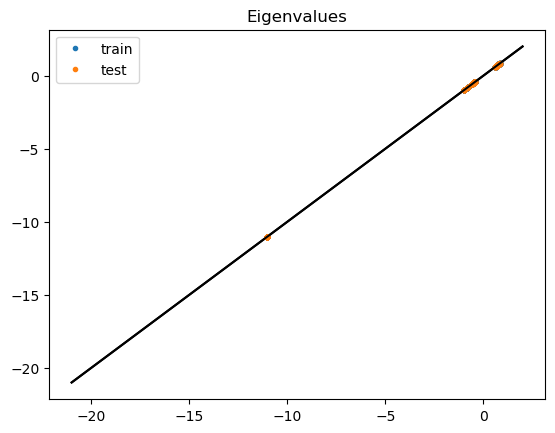

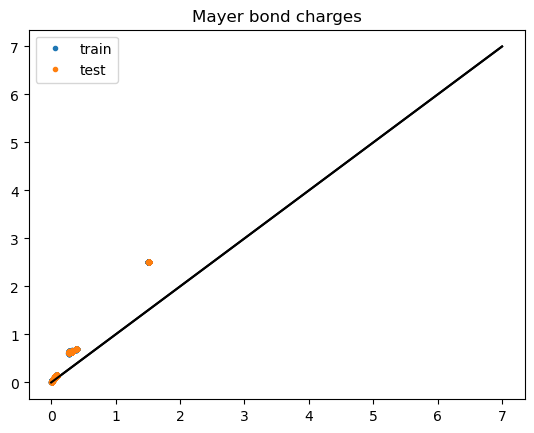

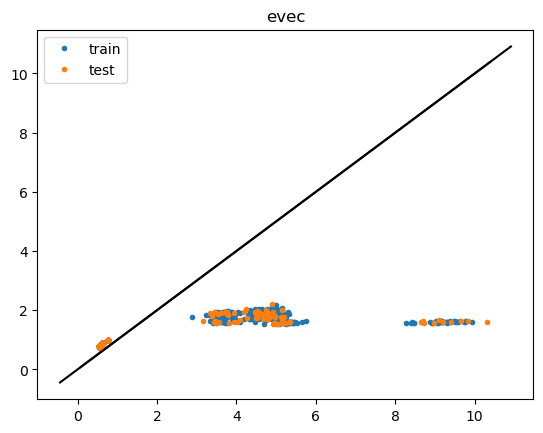

In [251]:
test_dl = DataLoader(mldata.val_dataset, batch_size = len(mldata.val_dataset), collate_fn=mldata.group_and_join)
train_dl = DataLoader(mldata.train_dataset, batch_size = len(mldata.train_dataset), collate_fn=mldata.group_and_join)

test_dl_small = DataLoader(mldata_small.val_dataset, batch_size = len(mldata.val_dataset), collate_fn=mldata.group_and_join)
train_dl_small = DataLoader(mldata_small.train_dataset, batch_size = len(mldata.train_dataset), collate_fn=mldata.group_and_join)

fig_e, ax_e = plt.subplots()
fig_a, ax_a = plt.subplots()
fig_evec, ax_evec = plt.subplots()

data = {}
for dl_, dl_small, lbl in zip([train_dl, test_dl], [train_dl_small, test_dl_small], ['train', 'test']):
    
    batch = next(iter(dl_))
    small_b = next(iter(dl_small))
    # pred = mts.sort(model(batch.features, small_b.fock_blocks))
    pred = mts.sort(model(batch.features, mldata.model_metadata))
    # pred = small_b.fock_blocks

    HT = blocks_to_matrix(pred, qmdata_sto3G, detach = True)
    HT = [HT[i][0,0,0] for i in batch.sample_id]
    
    pred_eigvals, pred_ard, pred_eigvec, pred_rho = compute_ard_vec(qmdata_sto3G, 
                                                                    batch, 
                                                                    HT, 
                                                                    device, 
                                                                    overlap = [qmdata_sto3G.overlap_realspace[i] for i in batch.sample_id])

    ax_e.plot(batch.eigenvalues[:,:n_eig_to_match].flatten(), pred_eigvals[:,:n_eig_to_match].detach().flatten(), '.', label = lbl)
    ax_e.plot([-21, 2], [-21, 2], 'k')
    ax_e.set_title('Eigenvalues')
    ax_e.legend()

    ax_a.plot(batch.atom_resolved_density.flatten(), pred_ard.detach().flatten(), '.', label = lbl)
    ax_a.plot([0,7], [0,7], 'k')
    ax_a.set_title('Mayer bond charges')
    ax_a.legend()

    pred_evn, targ_evn = torch.norm(pred_eigvec[:, :, :n_eig_to_match], dim = (1)), torch.norm(batch.eigenvectors[:, :, :n_eig_to_match], dim = (1))
    
    ax_evec.plot(targ_evn.flatten(), pred_evn.detach().flatten(), '.', label = lbl)
    xmin, xmax = ax_evec.get_xlim()
    ymin, ymax = ax_evec.get_ylim()
    xmin = np.min([xmin,ymin])
    xmax = np.max([xmax,ymax])
    ax_evec.plot([xmin,xmax], [xmin,xmax], 'k')
    ax_evec.set_title('evec')
    ax_evec.legend()

In [240]:
batch = next(iter(test_dl))
print(batch.sample_id)
dl_frames = [qmdata.structures[A] for A in batch.sample_id]

pred = model(batch.features, mldata.model_metadata)

HT = blocks_to_matrix(pred, qmdata_sto3G, detach = True)
HT = [HT[i][0,0,0] for i in batch.sample_id]

fock_predictions = torch.stack(HT)

fock_predictions = unfix_orbital_order(
    fock_predictions,
    dl_frames,
    qmdata_sto3G.basis,
)

fock_targets = unfix_orbital_order(
    batch.fock_realspace,
    dl_frames,
    mldata.qmdata.basis,
)

fock_sto3g = unfix_orbital_order(
    torch.stack([qmdata_sto3G.fock_realspace[i] for i in batch.sample_id]),
    dl_frames,
    qmdata_sto3G.basis,
)

over_large = unfix_orbital_order(
    batch.overlap_realspace,
    dl_frames,
    mldata.qmdata.basis,
)

over_small = unfix_orbital_order(
    torch.stack([qmdata_sto3G.overlap_realspace[i] for i in batch.sample_id]),
    dl_frames,
    qmdata_sto3G.basis,
)

with ipy_io.capture_output():
    dipole_targets = compute_dipole_moment(
        dl_frames,
        fock_targets,
        over_large,
        qmdata.basis_name
    )

with ipy_io.capture_output():
    dipole_predictions = compute_dipole_moment(
        dl_frames,
        fock_predictions,
        over_small,
        qmdata_sto3G.basis_name
    )

with ipy_io.capture_output():
    dipole_sto3g = compute_dipole_moment(
        dl_frames,
        fock_sto3g,
        over_small,
        qmdata_sto3G.basis_name
    )

(40, 41, 42, 43, 44, 45, 46, 47, 48, 49)


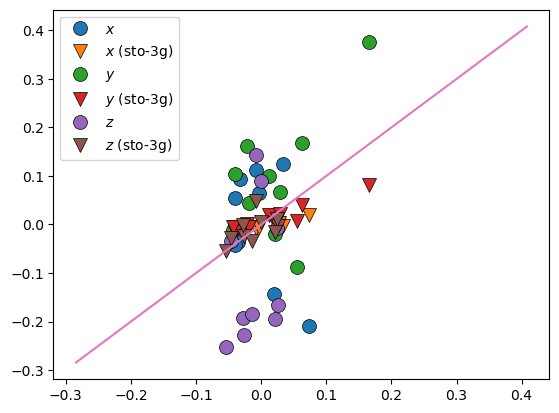

In [241]:
for i, x in enumerate(['$x$', '$y$', '$z$']):
    plt.plot(dipole_targets[:,i].flatten().detach().cpu(), dipole_predictions[:,i].flatten().detach().cpu(), 'o',
             markeredgewidth = 0.5,
             markeredgecolor = 'k',
             markersize = 10, 
             label = x, 
             alpha = 1)
    plt.plot(dipole_targets[:,i].flatten().detach().cpu(), dipole_sto3g[:,i].flatten().detach().cpu(), 'v', 
             markeredgewidth = 0.5,
             markeredgecolor = 'k',
             markersize = 10, 
             label = x + ' (sto-3g)', 
             alpha = 1)
plt.legend()

xm, xM = plt.xlim()
ym, yM = plt.ylim()
m = np.min([xm,ym])
M = np.max([xM,yM])
plt.plot([m,M], [m,M])

Text(0, 0.5, 'Predicted dipoles (D)')

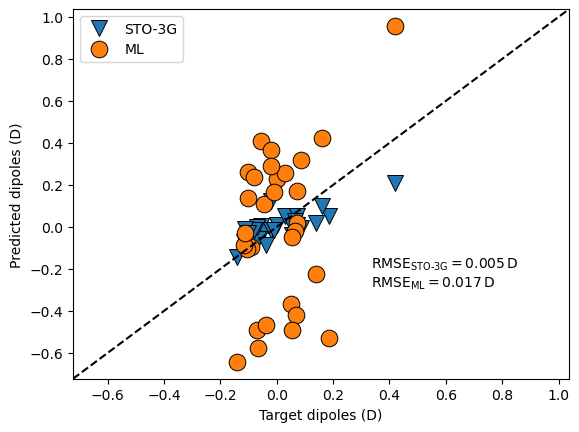

In [242]:
from ase.units import Bohr, Debye
au_to_debye = Bohr/Debye

ms = 12
mew = .7

fig, ax = plt.subplots()

x = dipole_targets.flatten().detach().cpu() * au_to_debye
y_sto3g = dipole_sto3g.flatten().detach().cpu() * au_to_debye
y_ml = dipole_predictions.flatten().detach().cpu() * au_to_debye

rmse_sto3g = np.sqrt(torch.mean(y_sto3g - x)**2)
rmse_ml = np.sqrt(torch.mean(y_ml - x)**2)

ax.plot(x, y_sto3g, 'v', 
         markeredgewidth = mew,
         markeredgecolor = 'k',
         markersize = ms, 
         label = 'STO-3G', 
         alpha = 1)

ax.plot(x, y_ml, 'o',
         markeredgewidth = mew,
         markeredgecolor = 'k',
         markersize = ms, 
         label = 'ML', 
         alpha = 1)

ax.legend()

xm, xM = ax.get_xlim()
ym, yM = ax.get_ylim()
m = np.min([xm,ym])
M = np.max([xM,yM])
ax.plot([m,M], [m,M], '--k')
ax.set_xlim(m, M)
ax.set_ylim(m, M)

ax.text(0.6, 0.3, fr'$\mathrm{{RMSE_{{\text{{STO-3G}}}}}}={rmse_sto3g:.3f}\,$D', transform = ax.transAxes, ha = 'left')
ax.text(0.6, 0.25, f'$\mathrm{{RMSE_{{ML}}}}={rmse_ml:.3f}\,$D', transform = ax.transAxes, ha = 'left')

ax.set_xlabel('Target dipoles (D)')
ax.set_ylabel('Predicted dipoles (D)')

# ax.set_title('Indirect training from def2-svp to a STO-3G-like model.\nTargets: eigenvalues; ARD; eigenvector norms over AOs\nTest set contains 50 water molecules')

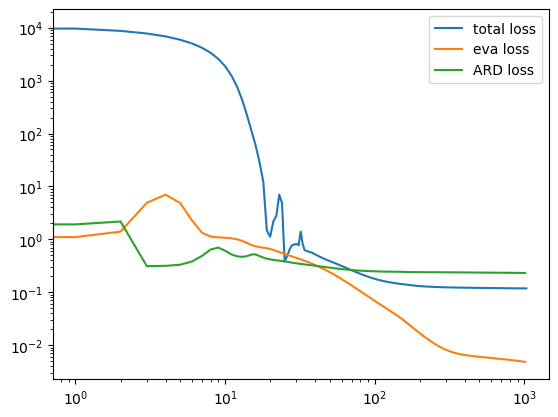

In [243]:
plt.loglog(losses, label="total loss")
plt.loglog(losses_e, label="eva loss",)
plt.loglog(losses_ard, label="ARD loss")
plt.legend()

In [140]:
a_ard = 0.5
a_e = 0.5

for epoch in range(nepoch):

    epoch_loss = 0
    epoch_loss_e = 0
    epoch_loss_evec = 0
    epoch_loss_ard = 0
    eig_sum = 0
    
    for ib, batch in enumerate(dl):
        
        model.train(True)
        optimizer.zero_grad()
        
        pred = model.forward(batch.features, mldata.model_metadata)

        HT = blocks_to_matrix(pred, qmdata_sto3G, detach = False)
        HT = [HT[i][0,0,0] for i in batch.sample_id] # Required for now

        pred_eigvals, pred_ard, pred_C, _ = compute_ard_vec(qmdata_sto3G, batch, HT, device, overlap = [qmdata_sto3G.overlap_realspace[i] for i in batch.sample_id])

        # loss_e = Eigval_loss(pred_eigvals[:, :n_eig_to_match], batch.eigenvalues[:, :n_eig_to_match])

        loss_e = torch.mean((pred_eigvals[:, :n_eig_to_match] - batch.eigenvalues[:, :n_eig_to_match])**2)
        loss_ard = torch.mean((pred_ard - batch.atom_resolved_density)**2)
        
        loss = a_ard*loss_ard + a_e*loss_e
        
        loss.backward()
        optimizer.step()

        epoch_loss_e += loss_e.item()
        epoch_loss_ard += loss_ard.item()
        epoch_loss += loss.item()

    # Compute factors
    if epoch > 5:
        c_ard = np.std(losses_ard[-10:]) / np.mean(losses_ard[-10:])
        c_e = np.std(losses_e[-10:]) / np.mean(losses_e[-10:])
        z_sum = c_ard + c_e
        
        a_ard = c_ard / z_sum
        a_e = c_e / z_sum
            
    scheduler.step(epoch_loss)
    losses.append(epoch_loss)
    losses_e.append(epoch_loss_e)
    losses_ard.append(epoch_loss_ard)
    
    if epoch >= 0: #% 10 == 0:
        print(f"Epoch {epoch:>7d}; lr={scheduler.get_last_lr()}; train loss {epoch_loss:>15.10f}; a_ard = {a_ard:.3e}; a_e = {a_e:.3e}; rmse_eig={np.sqrt(epoch_loss_e):>12.10f} rmse_evec={np.sqrt(epoch_loss_evec):>12.10f} rmse_ard={np.sqrt(epoch_loss_ard):>12.10f} ")

Epoch       0; lr=[0.005]; train loss   18.8325063455; a_ard = 5.000e-01; a_e = 5.000e-01; rmse_eig=5.3148228159 rmse_evec=0.0000000000 rmse_ard=3.0688224332 
Epoch       1; lr=[0.005]; train loss    4.7841418930; a_ard = 5.000e-01; a_e = 5.000e-01; rmse_eig=1.6466651355 rmse_evec=0.0000000000 rmse_ard=2.6185449619 
Epoch       2; lr=[0.005]; train loss    5.1606137792; a_ard = 5.000e-01; a_e = 5.000e-01; rmse_eig=2.2156052889 rmse_evec=0.0000000000 rmse_ard=2.3264395032 
Epoch       3; lr=[0.005]; train loss    3.8450513753; a_ard = 5.000e-01; a_e = 5.000e-01; rmse_eig=1.5222627246 rmse_evec=0.0000000000 rmse_ard=2.3179341984 
Epoch       4; lr=[0.005]; train loss    2.8739498966; a_ard = 5.000e-01; a_e = 5.000e-01; rmse_eig=1.0255515204 rmse_evec=0.0000000000 rmse_ard=2.1670588068 
Epoch       5; lr=[0.005]; train loss    2.4346396696; a_ard = 5.000e-01; a_e = 5.000e-01; rmse_eig=1.0366610534 rmse_evec=0.0000000000 rmse_ard=1.9479766938 
Epoch       6; lr=[0.005]; train loss    1.912

KeyboardInterrupt: 